<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Information-Bottleneck-for-Decision-Trees" data-toc-modified-id="Information-Bottleneck-for-Decision-Trees-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Information Bottleneck for Decision Trees</a></span><ul class="toc-item"><li><span><a href="#Decision-Trees-as-Learning-an-Optimal-Encoding" data-toc-modified-id="Decision-Trees-as-Learning-an-Optimal-Encoding-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Decision Trees as Learning an Optimal Encoding</a></span></li><li><span><a href="#Questions" data-toc-modified-id="Questions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Questions</a></span></li></ul></li><li><span><a href="#TODO" data-toc-modified-id="TODO-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>TODO</a></span></li><li><span><a href="#Implementation" data-toc-modified-id="Implementation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Implementation</a></span><ul class="toc-item"><li><span><a href="#Toy-data-sets" data-toc-modified-id="Toy-data-sets-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Toy data sets</a></span></li><li><span><a href="#Optimal-split" data-toc-modified-id="Optimal-split-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Optimal split</a></span><ul class="toc-item"><li><span><a href="#Loss:-entropy" data-toc-modified-id="Loss:-entropy-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Loss: entropy</a></span></li><li><span><a href="#Loss:-Categorical-Information-Bottleneck" data-toc-modified-id="Loss:-Categorical-Information-Bottleneck-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Loss: Categorical Information Bottleneck</a></span></li></ul></li><li><span><a href="#Tree" data-toc-modified-id="Tree-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Tree</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Train</a></span><ul class="toc-item"><li><span><a href="#Circle-regularized-with-IB,-$\beta=0.1$" data-toc-modified-id="Circle-regularized-with-IB,-$\beta=0.1$-3.4.1"><span class="toc-item-num">3.4.1&nbsp;&nbsp;</span>Circle regularized with IB, $\beta=0.1$</a></span></li><li><span><a href="#Circle,-regularized-with-max_depth=20" data-toc-modified-id="Circle,-regularized-with-max_depth=20-3.4.2"><span class="toc-item-num">3.4.2&nbsp;&nbsp;</span>Circle, regularized with <code>max_depth=20</code></a></span></li><li><span><a href="#Circle,-regularized-with-min_n" data-toc-modified-id="Circle,-regularized-with-min_n-3.4.3"><span class="toc-item-num">3.4.3&nbsp;&nbsp;</span>Circle, regularized with <code>min_n</code></a></span></li><li><span><a href="#Easy-data" data-toc-modified-id="Easy-data-3.4.4"><span class="toc-item-num">3.4.4&nbsp;&nbsp;</span>Easy data</a></span></li><li><span><a href="#Evaluate-Probability-to-end-up-in-a-leave-with-leave-size-N" data-toc-modified-id="Evaluate-Probability-to-end-up-in-a-leave-with-leave-size-N-3.4.5"><span class="toc-item-num">3.4.5&nbsp;&nbsp;</span>Evaluate Probability to end up in a leave with leave size N</a></span></li></ul></li><li><span><a href="#Impact-of-noise" data-toc-modified-id="Impact-of-noise-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Impact of noise</a></span></li><li><span><a href="#Generating-extra-features" data-toc-modified-id="Generating-extra-features-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Generating extra features</a></span></li><li><span><a href="#Utils" data-toc-modified-id="Utils-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Utils</a></span></li></ul></li><li><span><a href="#Scratch-Pad" data-toc-modified-id="Scratch-Pad-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Scratch Pad</a></span></li></ul></div>

# Information Bottleneck for Decision Trees

Decision trees are a class of machine learning algorithms that can be used for classification and regression problems. From an information theoretical perspective, they can be viewed as algorithms to construct optimal binary encodings $e: \mathcal{X} \mapsto \mathcal{B} $ for $\mathcal{B}$ being the set of binary words, and $\mathcal{X}$ being data sampled of an unkown distribution $P_X : \mathcal{X} \mapsto [0, 1]$.
It is interesting to analyze this in the information bottleneck framework (IB), which gives a justification to expect generalization.

**Objective of IB**
The IB objective is given as
$$ J'(e) = \beta I(X, e(X)) - I(e(X), y)  = \beta ( H(X) - H(X|e(X) ) - H(y) + H(y|e(X)) $$
If we ignore all terms independent of $e$, we get:
$$ J(e) =  H(y|e(X)) - \beta H(X|e(X)) $$

It is straight forward to apply the IB method to decision trees. The first term  $H(y|e(X))$ is a widely used objective in decision trees, and the second term $\beta H(X|e(X))$ serves as a regularizer. 

In the fitting phase, the tree tries to find a binary split $f(x) = x_i > t$ such that $J(f)$ is minimal. If the optimal split is a constant function over the samples, all points are grouped into the same split and the (sub)tree is a leaf. In this way, pruning is no longer necessary.

The loss function for a non-leaf tree can be expressed as:


$$  J = H(y|e(X)) - \beta H(X|e(X)) $$
$$ = \sum_{i=0}^1 ( P(e(X)=i) * (H(y|e(X)=i) - \beta H(X|e(X)=i)) ) $$
$$ = P(e(X)=0) * J(left) + P(e(X)=1) * J(right) $$

The loss of a leaf is simply:

$$    J = H(y|e(X)) - \beta H(X|e(X)) $$
$$      = H(y) - \beta H(X) $$

To estimate $H(X)$, we simply assume a uniform distribution over all samples, i.e. $-log(N)$.


This allows an efficient recursive computation of the loss.

- doing it in the split vs doing it as pruning

Generalization: IB and VC dimension

Prior of decision trees
- features are interpretable by themselves, which e.g. does not apply to images

Tradeoff: more flexible prior via new features vs increased VC dimension

Can we find an upper bound for $I(X, e(X)) \leq \psi(D)$?

## Decision Trees as Learning an Optimal Encoding

Decision trees are a class of machine learning algorithms that can be used for classification and regression problems. During training, a decision tree is fitted by greedily finding binary rules of the type $f(x) = x_i > t$. Here, $x \in R^D$ is a sample of the distribution $P_X$, and the objective is to find $f$ such that $I(X, f(X))$ is maximized.

This can be seen from an information theoretic perspective as constructing a 

## Questions
- How to deal with regression?
    - We need to approximate the differential entropy of y
    - Do we get an upper or lower bound by estimating p_y?
- Is the classification tree optimal in the sense of cross entropy?
- Is the regression tree optimal in the sense of MSE?
- Can we optimize for arbitrary loss functions?
    - Yes, and we can still use $\beta I(X, e(X))$ as regularizer


# TODO
- Mean only for regression trees, otherwise return probability distribution
- Print tree recursively
- Experiment: center data and reuse the same trees at a lower cost
- differential entropy
- optimal beta given N, d?
- plot2d

# Implementation

In [1]:
from scipy.special import xlogy
import numpy as np
from matplotlib import pyplot as plt


def entropy(y):
    """Return the empirical entropy of samples y of 
    a categorical distribution

    Arguments:
        y: np.array (N, C) , categorical labels
    Returns:
        H: float
    """
    if len(y) == 0:
        return 0
    py = y.mean(0)
    h = -np.sum(xlogy(py, py))
    return h


def plot_entropy_of_bernoulli():
    p = []
    h = []
    for t in range(1000):
        p += [t/1000]
        y = np.zeros((1000, 2))
        y[:t, 0] = 1
        y[t:, 1] = 1
        h += [entropy(y)]

    plt.plot(p, h)
    plt.xlabel("t")
    plt.ylabel("H")
    plt.title("Entropy of Bernoulli_t")
    plt.show()


plot_entropy_of_bernoulli()

<Figure size 640x480 with 1 Axes>

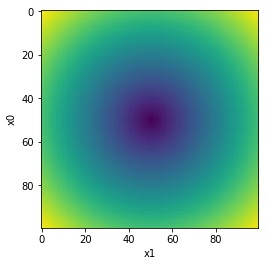

In [2]:
def grid2d(N):
    """
    Create an (N*N, 2) matrix of samples on a grid of [0,1]x[0,1]
    """
    X = np.zeros((N*N, 2))
    X[:, 0] = np.repeat(np.arange(0, 1, 1/N), N)
    X[:, 1] = np.arange(0, N, 1/N) % 1
    return X-np.array([0.5, 0.5])


X = grid2d(100)
y = np.linalg.norm(X, axis=1)


def plot_on_grid(y, N):
    plt.imshow(y.reshape((N, N)))
    plt.xlabel("x1")
    plt.ylabel("x0")
    plt.show()


plot_on_grid(y, 100)

## Toy data sets

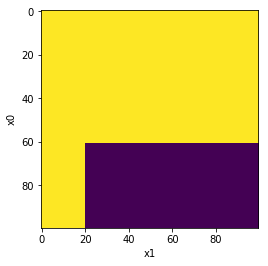

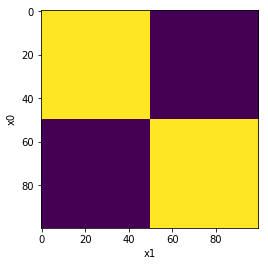

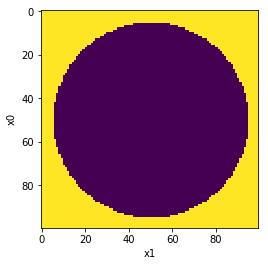

(array([[-0.5 , -0.5 ],
        [-0.5 , -0.49],
        [-0.5 , -0.48],
        ...,
        [ 0.49,  0.47],
        [ 0.49,  0.48],
        [ 0.49,  0.49]]), array([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]]))

In [30]:
def easy_data():
    X = grid2d(100)
    y = np.zeros((10000, 2))
    y[X[:, 0] < 0.1, 0] = 1
    y[X[:, 1] < -0.3, 0] = 1
    y[:, 1] = 1 - y.sum(1)
    plot_on_grid(y[:, 0], 100)
    return X, y


easy_data()


def caro_data():
    X = grid2d(100)
    y = np.zeros((10000, 2))
    y[(X[:, 0] < 0) == (X[:, 1] < 0), 0] = 1
    y[:, 1] = 1 - y.sum(1)
    plot_on_grid(y[:, 0], 100)
    return X, y


caro_data()


def circle_data():
    X = grid2d(100)
    y = np.zeros((10000, 2))
    y[np.square(X).sum(1) > 0.2, 0] = 1
    y[:, 1] = 1 - y.sum(1)
    plot_on_grid(y[:, 0], 100)
    return X, y


circle_data()

## Optimal split

In [4]:
def smooth(y, window=None, mode='valid'):
    window = window or min(max(len(y)//30, 2), 20)
    return np.convolve(np.ones(window)/window, y, mode=mode)

In [5]:
def optimal_split_plot(X, y, J):
    plt.figure(figsize=(14, 6))
    c = plt.rcParams['axes.prop_cycle'].by_key()['color']
    N, d = X.shape
    for i in range(d):
        x = X[:, i]
        sort = np.argsort(x)
        x, y = x[sort], y[sort]
        best_loss = np.inf
        best_split_idx = 0
        h = []
        eval_treshhold = np.unique(x)
        for t in eval_treshhold:
            # evaluate loss for splitting [:s], [s:]
            y_l = y[x <= t]
            y_r = y[x > t]
            s = len(y_l)
            loss = J(y_l)*s/N + J(y_r)*(N-s)/N
            h.append(loss)

        plt.subplot(121)
        plt.plot(eval_treshhold, h, label=i, color=c[i])
        plt.subplot(122)
        plt.plot(smooth(y[:, 0], window=len(y)//10), color=c[i])
        plt.plot(smooth(y[:, 1], window=len(y)//10), color=c[i])

    plt.subplot(121)
    plt.xlabel("Threshhold")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(122)
    plt.xlabel("Split index")
    plt.ylabel("Y")
    plt.show()

### Loss: entropy

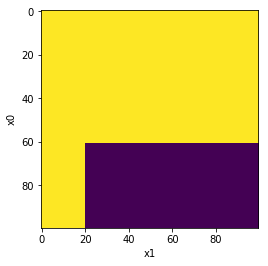

/Users/nielswarncke/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


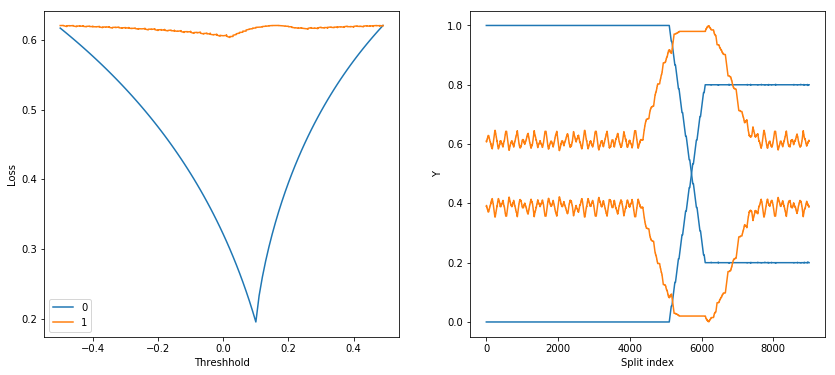

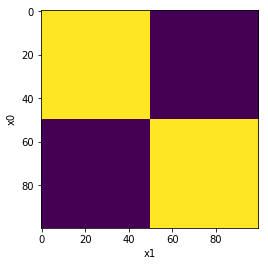

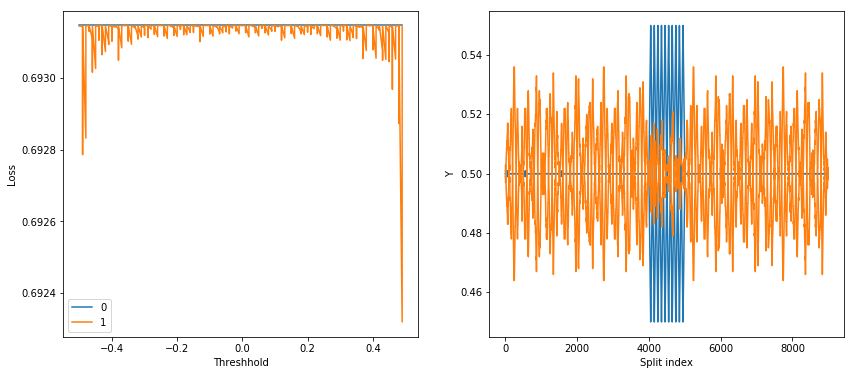

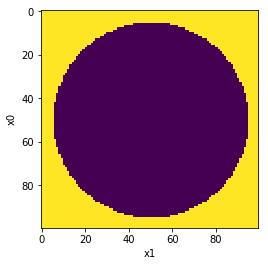

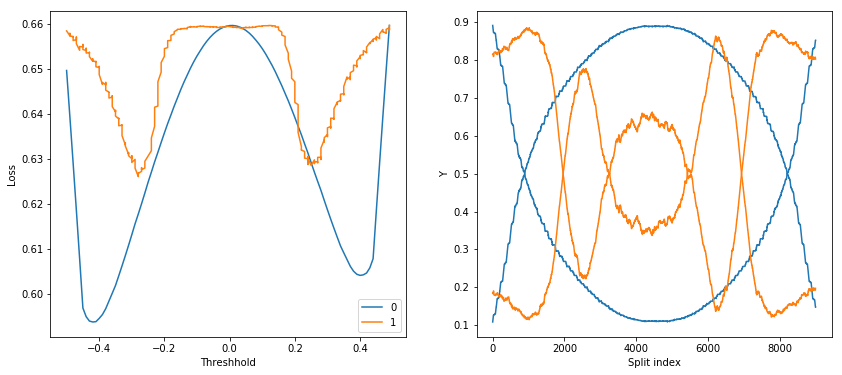

In [6]:
X, y = easy_data()
optimal_split_plot(X, y, entropy)
X, y = caro_data()
optimal_split_plot(X, y, entropy)
X, y = circle_data()
optimal_split_plot(X, y, entropy)

### Loss: Categorical Information Bottleneck

In [7]:
def categorical_IB(beta):
    def J(y):
        if len(y) == 0:
            return 0
        return entropy(y) - beta*np.log(len(y))
    return J

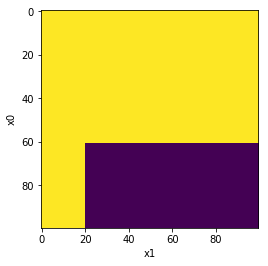

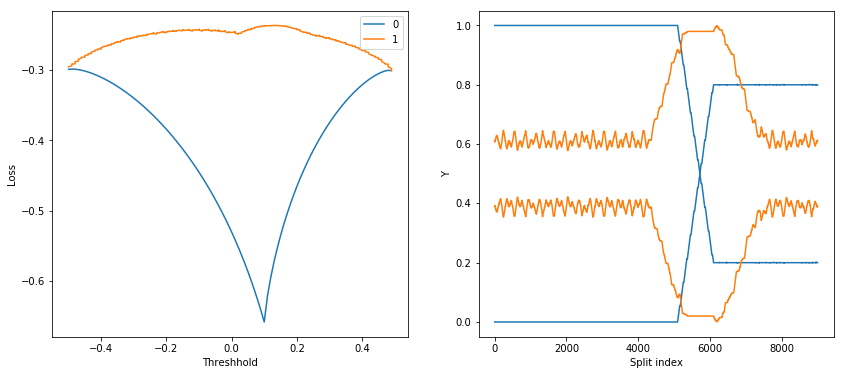

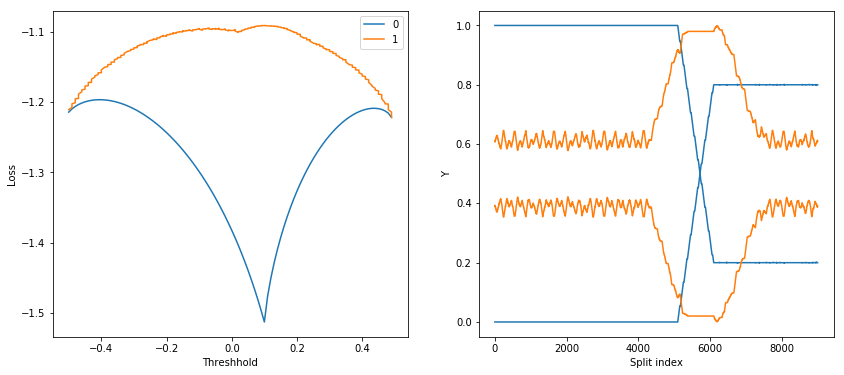

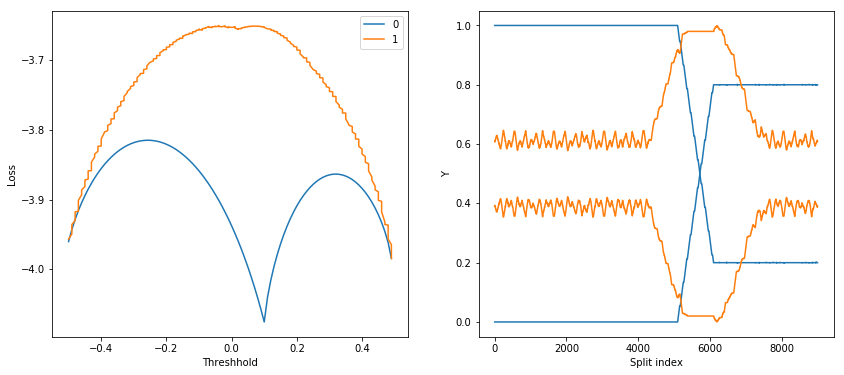

In [8]:
X, y = easy_data()
optimal_split_plot(X, y, categorical_IB(0.1))
optimal_split_plot(X, y, categorical_IB(0.2))
optimal_split_plot(X, y, categorical_IB(0.5))

## Tree

In [124]:
import pdb


def differential_entropy(y):
    pass


def optimal_split(x, y, J, min_n):
    N = len(x)
    best_loss = np.inf
    best_t = -np.inf
    ts = np.unique(x)
    ts = ts[::max(1, len(ts)//100)]
    for t in ts:
        # evaluate loss for splitting [:s], [s:]
        y_l = y[x <= t]
        y_r = y[x > t]
        s = len(y_l)
        loss = J(y_l)*s/N + J(y_r)*(N-s)/N
        if loss < best_loss and s >= min_n and s <= N-min_n:
            best_loss = loss
            best_t = t
    return best_t, best_loss


def categorical_IB(beta):
    def J(y):
        if len(y) == 0:
            return 0
        return entropy(y) - beta*np.log(len(y))
    return J


class DecisionTree():
    def __init__(self,
                 J,
                 _prefix="Tree",
                 root=None,
                 min_n=1,
                 max_depth=1000,
                 plot_optimal_split=False,
                 random_projections=False # False or int num_projections
        ):
        self.split_dim = 0
        self.J = J
        self.root = root or self
        self.min_n = min_n
        self.max_depth = max_depth
        self.threshhold = -np.inf
        self.loss = np.inf
        self.leaf_loss = np.inf
        self.left = None
        self.right = None
        self.mean = None
        self.x_mean = None
        self.x_min = None
        self.x_max = None
        self._N = None
        self._prefix = _prefix
        self.n_leaves = 1
        self.depth = 1
        self.plot_optimal_split = plot_optimal_split
        self.rand_id = np.random.rand()
        self.random_projections = random_projections
        self.D = None
        
    def apply_random_projections(self, X):
        if self.D is None:
            N, d = X.shape
            D = np.random.normal(0, 1, size=(d, self.random_projections))
            D = D/np.linalg.norm(D, axis=1, keepdims=True)
            self.D = D
        else:
            D = self.D
        return X@D
    
    @property
    def is_leaf(self):
        return self.left is None and self.right is None

    def check_input(self, X, y):
        assert (len(X) == len(y) and X.ndim == 2 and y.ndim ==
                2), f"Unexpected shapes: \n  X: {X.shape}\n  y: {y.shape}"
        assert y.sum(1).mean() == 1, "Expected one hot encoded labels"

    def fit(self, X, y):
        self.check_input(X, y)
        if self.random_projections:
            X = self.apply_random_projections(X)
        self.mean = y.mean(axis=0)
        # Track the own domain for later plotting
        self.mean_x = x.mean(0)
        self.min_x = x.min(0)
        self.max_x = x.max(0)
        #
        self._N = len(X)
        self.leaf_loss = self.J(y)
        N, d = X.shape
        if self.mean.max() == 1 or N < self.min_n or self.max_depth < 1:
            self.loss = self.leaf_loss
            return self
        best_t_idx = None
        for i in range(d):
            t, j = optimal_split(X[:, i], y, self.J, self.min_n)
            if j < self.loss:
                self.threshhold, self.loss, self.split_dim = t, j, i
        if self.root.plot_optimal_split:
            optimal_split_plot(X, y, self.J)

        if self.loss < self.leaf_loss:
            self.left = DecisionTree(
                self.J,
                _prefix=f"{self._prefix} and \\ \n    x[{self.split_dim}] <= {self.threshhold}",
                root=self.root,
                min_n=self.min_n,
                max_depth=self.max_depth-1
            )
            self.left.fit(
                X[X[:, self.split_dim] <= self.threshhold],
                y[X[:, self.split_dim] <= self.threshhold]
            )
            self.right = DecisionTree(
                self.J,
                _prefix=f"{self._prefix} and \\ \n    x[{self.split_dim}] > {self.threshhold}",
                root=self.root,
                min_n=self.min_n,
                max_depth=self.max_depth-1
            )
            self.right.fit(
                X[X[:, self.split_dim] > self.threshhold],
                y[X[:, self.split_dim] > self.threshhold]
            )
            self.loss = self.left.loss * (self.left._N / self._N) + \
                self.right.loss * (self.right._N / self._N)
            self.n_leaves = self.left.n_leaves + self.right.n_leaves
            self.depth = max(self.left.depth, self.right.depth) + 1
        else:
            self.loss = self.leaf_loss
        return self

    def print_node(self, prefix=""):
        print(f"{prefix} >> N: {self.mean}")
        print(f"{prefix} >> N: {self._N}")
        print(f"{prefix} >> J: {self.leaf_loss:.2f}")
        print(f"{prefix} >> Acc: {self.mean.max():.2f}")

    def print_tree(self, prefix=""):
        if self.is_leaf:
            self.print_node(prefix)
        else:
            print(
                f"{prefix} X_{self.split_dim} <= {self.threshhold} : {self.left._N} vs {self._N-self.left._N}")
            self.left.print_tree(prefix+"  |")
            if self.right is not None:
                print(f"{prefix} X_{self.split_dim} > {self.threshhold}")
                self.right.print_tree(prefix+"  |")

    def get_leaves(self):
        if self.is_leaf:
            return [self]
        return self.left.get_leaves() + self.right.get_leaves()

    def plot_2d_tree(self):
        # Plot box
        plt.plot([self.min_x[0], self.max_x[0]],
                 [self.min_x[1], self.min_x[1]])
        plt.plot([self.min_x[0], self.max_x[0]],
                 [self.max_x[1], self.max_x[1]])
        plt.plot([self.min_x[0], self.min_x[0]],
                 [self.min_x[1], self.max_x[1]])
        plt.plot([self.max_x[0], self.max_x[0]],
                 [self.min_x[1], self.max_x[1]])
        # Plot center
        # plot lines from center to children
        plt.plot()
        pass

    def encode_single(self, x):
        """Return binary encoding as List of Booleans and the residual
        """
        if self.is_leaf:
            return [], x-self.mean
        if x[self.split_dim] < self.threshhold:
            enc, res = self.left.encode_single(x)
            return [True] + enc, res
        else:
            enc, res = self.right.encode_single(x)
            return [False] + enc, res

    def predict_single(self, x):
        """Works on projected data"""
        if self.is_leaf:
            return self.mean
        if x[self.split_dim] <= self.threshhold:
            return self.left.predict_single(x)
        else:
            return self.right.predict_single(x)

    def predict(self, X):
        if self.random_projections:
            X = self.apply_random_projections(X)
        return np.array([self.predict_single(x) for x in X])

    def color_single(self, x, depth):
        if self.is_leaf or depth == 0:
            return 0
        if x[self.split_dim] <= self.threshhold:
            return self.left.color_single(x, depth-1) + 1 - self.rand_id/10
        else:
            return self.right.color_single(x, depth-1) + 1 + self.rand_id/10

    def color(self, X, depth=None):
        if self.random_projections:
            X = self.apply_random_projections(X)
        depth = depth or self.depth
        return np.array([self.color_single(x, depth) for x in X])

## Train


### Circle regularized with IB, $\beta=0.1$

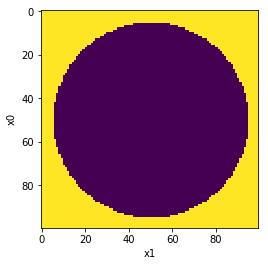

 X_1 <= -0.4099999999999999 : 932 vs 9068
  | X_1 <= -0.4399999999999995 : 624 vs 308
  |  | >> N: 624
  |  | >> J: -0.08
  |  | >> Acc: 1.00
  | X_1 > -0.4399999999999995
  |  | X_0 <= -0.15999999999999998 : 113 vs 195
  |  |  | >> N: 113
  |  |  | >> J: -0.06
  |  |  | >> Acc: 1.00
  |  | X_0 > -0.15999999999999998
  |  |  | X_0 <= 0.15000000000000002 : 93 vs 102
  |  |  |  | X_1 <= -0.4299999999999926 : 62 vs 31
  |  |  |  |  | X_0 <= -0.08999999999999997 : 14 vs 48
  |  |  |  |  |  | >> N: 14
  |  |  |  |  |  | >> J: 0.57
  |  |  |  |  |  | >> Acc: 0.71
  |  |  |  |  | X_0 > -0.08999999999999997
  |  |  |  |  |  | X_0 <= 0.07999999999999996 : 34 vs 14
  |  |  |  |  |  |  | >> N: 34
  |  |  |  |  |  |  | >> J: -0.04
  |  |  |  |  |  |  | >> Acc: 1.00
  |  |  |  |  |  | X_0 > 0.07999999999999996
  |  |  |  |  |  |  | >> N: 14
  |  |  |  |  |  |  | >> J: 0.57
  |  |  |  |  |  |  | >> Acc: 0.71
  |  |  |  | X_1 > -0.4299999999999926
  |  |  |  |  | >> N: 31
  |  |  |  |  | >> J: -0.04


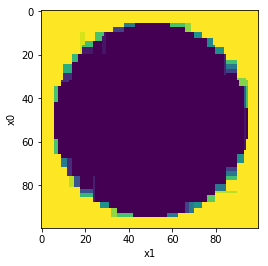

Tree with 98 leaves and depth of 13


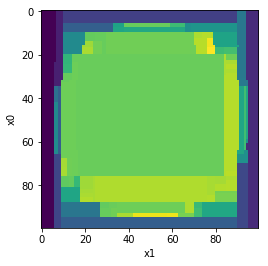

In [82]:
tree = DecisionTree(categorical_IB(beta=0.0125))
X, y = circle_data()
tree.fit(X, y)
tree.print_tree()
y_pred = tree.predict(X)
plot_on_grid(y_pred[:, 0], 100)

print(f"Tree with {tree.n_leaves} leaves and depth of {tree.depth}")
structure = tree.color(X)
plot_on_grid(structure, 100)

### Circle, regularized with `max_depth=20`

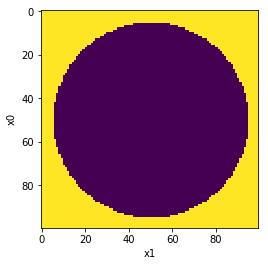

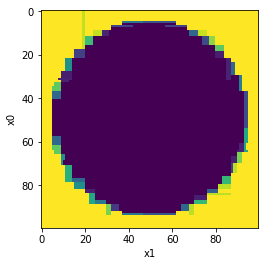

Tree with 117 leaves and depth of 18


In [11]:
tree = DecisionTree(entropy, max_depth=20)
X, y = circle_data()
tree.fit(X, y)
y_pred = tree.predict(X)
plot_on_grid(y_pred[:, 0], 100)

print(f"Tree with {tree.n_leaves} leaves and depth of {tree.depth}")

### Circle, regularized with `min_n`

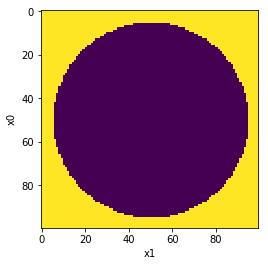

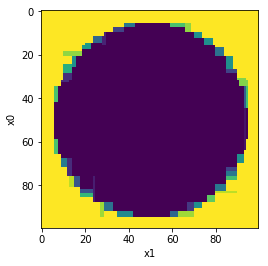

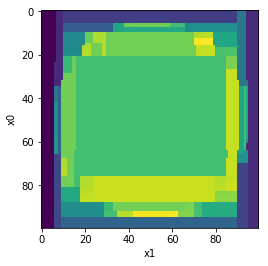

Tree with 95 leaves and depth of 13


In [66]:
tree = DecisionTree(entropy, min_n=10)
X, y = circle_data()
tree.fit(X, y)
y_pred = tree.predict(X)
plot_on_grid(y_pred[:, 0], 100)
structure = tree.color(X)
plot_on_grid(structure, 100)
print(f"Tree with {tree.n_leaves} leaves and depth of {tree.depth}")

### Easy data

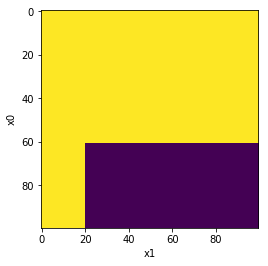

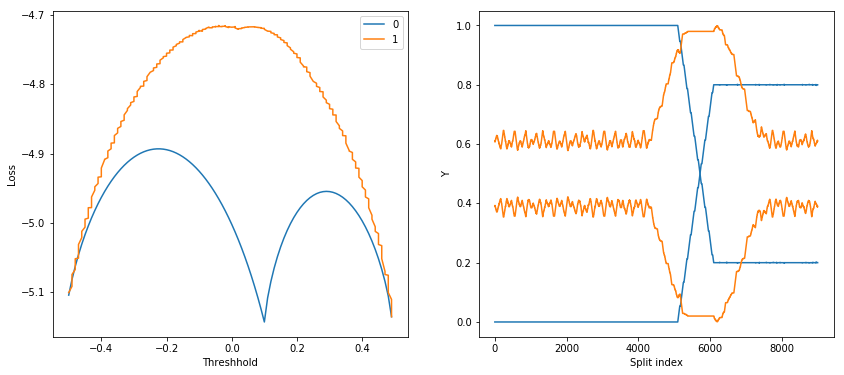

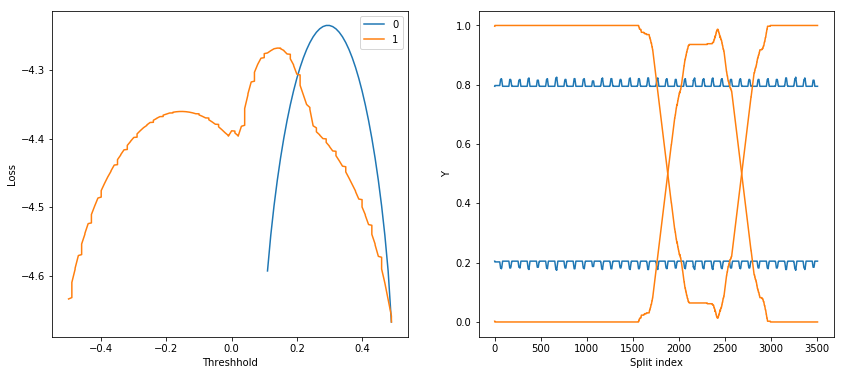

Learned function:


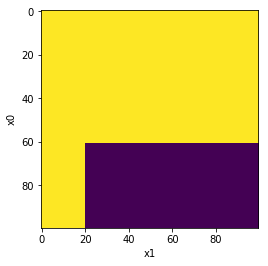

Structure of the tree


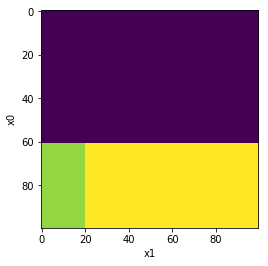

Tree with 3 leaves and depth of 3


In [76]:
# y[X[:,0]<0.1,0] = 1
# y[X[:,1]<-0.3,0] = 1

tree = DecisionTree(categorical_IB(beta=0.625),
                    max_depth=2, plot_optimal_split=True)
X, y = easy_data()
tree.fit(X, y)
y_pred = tree.predict(X)
print("Learned function:")
plot_on_grid(y_pred[:, 0], 100)

print("Structure of the tree")
structure = tree.color(X)
plot_on_grid(structure, 100)
print(f"Tree with {tree.n_leaves} leaves and depth of {tree.depth}")

### Evaluate Probability to end up in a leave with leave size N

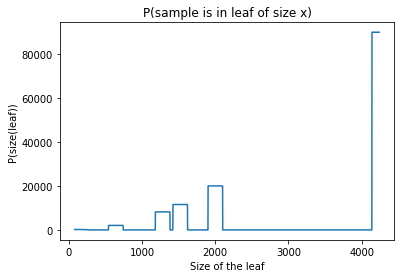

In [21]:
def fill_missing_x_with(x, y, fill=0):
    c = dict(zip(x.tolist(), y.tolist()))
    x = np.arange(x.min(), x.max()+0.5, 1)
    y = np.array([c.get(s, 0)*s for s in x])
    return x, y


leaves = tree.get_leaves()
leaf_size = [i._N for i in leaves]
sizes, counts = np.unique(leaf_size, return_counts=True)
x, p_in_leav_of_size = fill_missing_x_with(sizes, sizes*counts, fill=0)
plt.plot(x, smooth(p_in_leav_of_size, mode='same', window=200))
plt.xlabel("Size of the leaf")
plt.ylabel("P(size(leaf))")
plt.title("P(sample is in leaf of size x)")
plt.show()

## Impact of noise

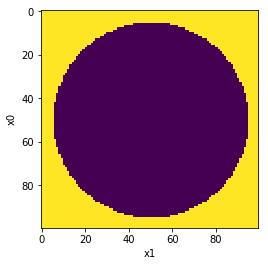

 X_0 <= -0.38532795889307386 : 1201 vs 8799
  | X_1 <= -0.2766570589443936 : 277 vs 924
  |  | X_1 <= -0.4019402045630016 : 135 vs 142
  |  |  | >> N: [1. 0.]
  |  |  | >> N: 135
  |  |  | >> J: -0.00
  |  |  | >> Acc: 1.00
  |  | X_1 > -0.4019402045630016
  |  |  | X_0 <= -0.4632917452854483 : 60 vs 82
  |  |  |  | >> N: [1. 0.]
  |  |  |  | >> N: 60
  |  |  |  | >> J: -0.00
  |  |  |  | >> Acc: 1.00
  |  |  | X_0 > -0.4632917452854483
  |  |  |  | X_0 <= -0.43463776123327486 : 29 vs 53
  |  |  |  |  | X_0 <= -0.4512903106639837 : 10 vs 19
  |  |  |  |  |  | >> N: [0.8 0.2]
  |  |  |  |  |  | >> N: 10
  |  |  |  |  |  | >> J: 0.50
  |  |  |  |  |  | >> Acc: 0.80
  |  |  |  |  | X_0 > -0.4512903106639837
  |  |  |  |  |  | >> N: [0.94736842 0.05263158]
  |  |  |  |  |  | >> N: 19
  |  |  |  |  |  | >> J: 0.21
  |  |  |  |  |  | >> Acc: 0.95
  |  |  |  | X_0 > -0.43463776123327486
  |  |  |  |  | >> N: [1. 0.]
  |  |  |  |  | >> N: 53
  |  |  |  |  | >> J: -0.00
  |  |  |  |  | >> Acc: 

  |  |  |  |  |  |  |  |  | >> N: 11
  |  |  |  |  |  |  |  |  | >> J: -0.00
  |  |  |  |  |  |  |  |  | >> Acc: 1.00
  |  |  |  |  |  |  |  | X_0 > 0.3159221060075093
  |  |  |  |  |  |  |  |  | X_0 <= 0.32399620502944687 : 10 vs 31
  |  |  |  |  |  |  |  |  |  | >> N: [0.6 0.4]
  |  |  |  |  |  |  |  |  |  | >> N: 10
  |  |  |  |  |  |  |  |  |  | >> J: 0.67
  |  |  |  |  |  |  |  |  |  | >> Acc: 0.60
  |  |  |  |  |  |  |  |  | X_0 > 0.32399620502944687
  |  |  |  |  |  |  |  |  |  | X_0 <= 0.3521107077445609 : 17 vs 14
  |  |  |  |  |  |  |  |  |  |  | >> N: [1. 0.]
  |  |  |  |  |  |  |  |  |  |  | >> N: 17
  |  |  |  |  |  |  |  |  |  |  | >> J: -0.00
  |  |  |  |  |  |  |  |  |  |  | >> Acc: 1.00
  |  |  |  |  |  |  |  |  |  | X_0 > 0.3521107077445609
  |  |  |  |  |  |  |  |  |  |  | >> N: [0.85714286 0.14285714]
  |  |  |  |  |  |  |  |  |  |  | >> N: 14
  |  |  |  |  |  |  |  |  |  |  | >> J: 0.41
  |  |  |  |  |  |  |  |  |  |  | >> Acc: 0.86
  |  |  |  | X_1 > 0.42355765167

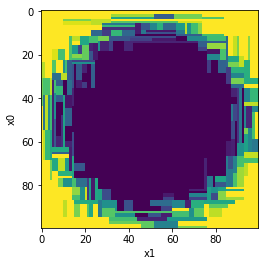

Tree with 352 leaves and depth of 18


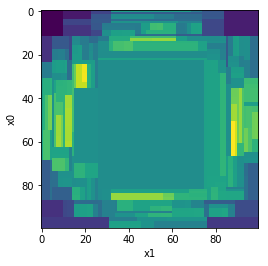

In [128]:
def uniform_label_noise(y, p_noise=0.1):
    y[:, 0] += np.round(np.random.uniform(low=0,
                                          high=0.5+p_noise/2, size=len(y)))
    y = y % 2
    y[:, 1] = 1 - y[:, 0]
    return y

X, y = circle_data()
# y = uniform_label_noise(y)

tree = DecisionTree(categorical_IB(beta=0), min_n=10)
tree.fit(X_train, y)

tree.print_tree()
y_pred = tree.predict(X)
plot_on_grid(y_pred[:, 0], 100)

print(f"Tree with {tree.n_leaves} leaves and depth of {tree.depth}")
structure = tree.color(X)
plot_on_grid(structure, 100)

## Generating extra features

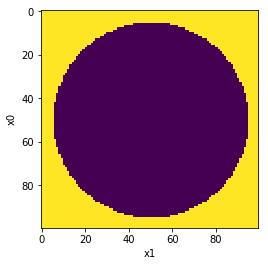

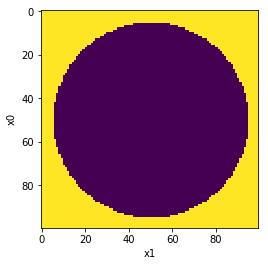

 X_1 <= 0.20943353984356752 : 9001 vs 999
  | X_4 <= 0.060619618445416974 : 8101 vs 900
  |  | X_9 <= -0.09338405118488688 : 1702 vs 6399
  |  |  | X_3 <= -0.18174890223650345 : 562 vs 1140
  |  |  |  | X_3 <= -0.20482411122531755 : 336 vs 226
  |  |  |  |  | X_4 <= -0.01800283317170167 : 10 vs 326
  |  |  |  |  |  | >> N: [0.9 0.1]
  |  |  |  |  |  | >> N: 10
  |  |  |  |  |  | >> J: 0.33
  |  |  |  |  |  | >> Acc: 0.90
  |  |  |  |  | X_4 > -0.01800283317170167
  |  |  |  |  |  | >> N: [1. 0.]
  |  |  |  |  |  | >> N: 326
  |  |  |  |  |  | >> J: -0.00
  |  |  |  |  |  | >> Acc: 1.00
  |  |  |  | X_3 > -0.20482411122531755
  |  |  |  |  | X_1 <= -0.24426986852140084 : 53 vs 173
  |  |  |  |  |  | X_7 <= 0.2119758322715402 : 21 vs 32
  |  |  |  |  |  |  | >> N: [1. 0.]
  |  |  |  |  |  |  | >> N: 21
  |  |  |  |  |  |  | >> J: -0.00
  |  |  |  |  |  |  | >> Acc: 1.00
  |  |  |  |  |  | X_7 > 0.2119758322715402
  |  |  |  |  |  |  | X_2 <= 0.21513617560174592 : 20 vs 12
  |  |  |  |  |

  |  |  |  |  |  |  |  |  |  |  |  |  |  | >> J: 0.24
  |  |  |  |  |  |  |  |  |  |  |  |  |  | >> Acc: 0.93
  |  |  |  |  |  |  |  | X_4 > 0.016492642801973118
  |  |  |  |  |  |  |  |  | X_3 <= -0.15303869220596963 : 15 vs 12
  |  |  |  |  |  |  |  |  |  | >> N: [0.46666667 0.53333333]
  |  |  |  |  |  |  |  |  |  | >> N: 15
  |  |  |  |  |  |  |  |  |  | >> J: 0.69
  |  |  |  |  |  |  |  |  |  | >> Acc: 0.53
  |  |  |  |  |  |  |  |  | X_3 > -0.15303869220596963
  |  |  |  |  |  |  |  |  |  | >> N: [0.25 0.75]
  |  |  |  |  |  |  |  |  |  | >> N: 12
  |  |  |  |  |  |  |  |  |  | >> J: 0.56
  |  |  |  |  |  |  |  |  |  | >> Acc: 0.75
  |  | X_9 > -0.09338405118488688
  |  |  | X_5 <= -0.10216399296312187 : 631 vs 5768
  |  |  |  | X_5 <= -0.12363166928375853 : 229 vs 402
  |  |  |  |  | X_6 <= -0.43307531774585944 : 143 vs 86
  |  |  |  |  |  | X_0 <= -0.021027960915336704 : 25 vs 118
  |  |  |  |  |  |  | >> N: [1. 0.]
  |  |  |  |  |  |  | >> N: 25
  |  |  |  |  |  |  | >> J: -0.

  |  |  |  |  |  |  |  |  |  |  |  |  | >> N: [0. 1.]
  |  |  |  |  |  |  |  |  |  |  |  |  | >> N: 22
  |  |  |  |  |  |  |  |  |  |  |  |  | >> J: -0.00
  |  |  |  |  |  |  |  |  |  |  |  |  | >> Acc: 1.00
  |  |  |  |  |  |  |  |  |  |  |  | X_0 > -0.015069570487571354
  |  |  |  |  |  |  |  |  |  |  |  |  | X_5 <= -0.10064708568566619 : 20 vs 23
  |  |  |  |  |  |  |  |  |  |  |  |  |  | X_0 <= 0.0021443302250272237 : 10 vs 10
  |  |  |  |  |  |  |  |  |  |  |  |  |  |  | >> N: [0.3 0.7]
  |  |  |  |  |  |  |  |  |  |  |  |  |  |  | >> N: 10
  |  |  |  |  |  |  |  |  |  |  |  |  |  |  | >> J: 0.61
  |  |  |  |  |  |  |  |  |  |  |  |  |  |  | >> Acc: 0.70
  |  |  |  |  |  |  |  |  |  |  |  |  |  | X_0 > 0.0021443302250272237
  |  |  |  |  |  |  |  |  |  |  |  |  |  |  | >> N: [0.2 0.8]
  |  |  |  |  |  |  |  |  |  |  |  |  |  |  | >> N: 10
  |  |  |  |  |  |  |  |  |  |  |  |  |  |  | >> J: 0.50
  |  |  |  |  |  |  |  |  |  |  |  |  |  |  | >> Acc: 0.80
  |  |  |  |  |  |  |  |  | 

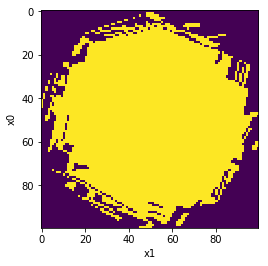

Tree with 337 leaves and depth of 19


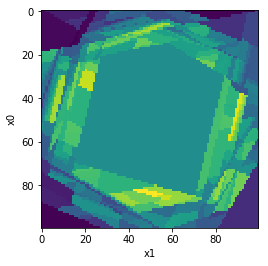

In [129]:
X, y = circle_data()
# y = uniform_label_noise(y)
plot_on_grid(y[:, 0], 100)


tree = DecisionTree(categorical_IB(beta=0), random_projections=10, min_n=10)
tree.fit(X_train, y)
tree.print_tree()
y_pred = tree.predict(X)
plot_on_grid(y_pred.argmax(1), 100)

print(f"Tree with {tree.n_leaves} leaves and depth of {tree.depth}")
structure = tree.color(X)
plot_on_grid(structure, 100)

## Utils

In [15]:
import pdb


def debug(f):
    def debugged(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except Exception as e:
            print(type(e), e)
            pdb.set_trace()
            f(*args, **kwargs)
    return debugged

# Scratch Pad

In [77]:
tree.print_tree()

 X_0 <= 0.09999999999999998 : 6100 vs 3900
  | >> N: 6100
  | >> J: -5.45
  | >> Acc: 1.00
 X_0 > 0.09999999999999998
  | X_1 <= -0.30999999999999517 : 780 vs 3120
  |  | >> N: 780
  |  | >> J: -4.16
  |  | >> Acc: 1.00
  | X_1 > -0.30999999999999517
  |  | >> N: 3120
  |  | >> J: -5.03
  |  | >> Acc: 1.00


In [17]:
optimal_split(X[:, 5], y, categorical_IB(0))

IndexError: index 5 is out of bounds for axis 1 with size 2